<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_3_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [7. 앙상블 학습과 랜덤 포레스트]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 7.1 투표 기반 분류기
직접 투표 분류기 : 다수결 투표로 정해지는 분류기  
약한 학습기 : 랜덤 추측보다 조금 더 높은 성능을 내는 분류기 (<-> 강한 학습기)

* 여러 분류기를 조합하여 투표 기반 분류기를 만들고 훈련시키기


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

* 각 분류기의 테스트셋 정확도 확인

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9
RandomForestClassifier 0.9
SVC 0.9
VotingClassifier 0.9


* 간접 투표 : 모든 분류기가 predict_proba() 메서드가 있으면, 즉 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음
* 직접 투표보다 성능이 높고 voting='soft'로 바꾸면 됨
* SVC는 predict_proba() 메서드를 사용하기 위해 probability=True로 설정해야 함

### 7.2 배깅과 페이스팅
배깅(bootstrap aggregating) : 훈련 세트에서 중복을 허용하여 샘플링하는 방식  
페이스팅 : 중복 허용하지 않고 샘플링하는 방식

#### 7.2.1 사이킷런의 배깅과 페이스팅
* BaggingClassifier 사용
* 아래 코드는 배깅, 페이스팅을 사용하려면 bootstrap=False로 지정

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

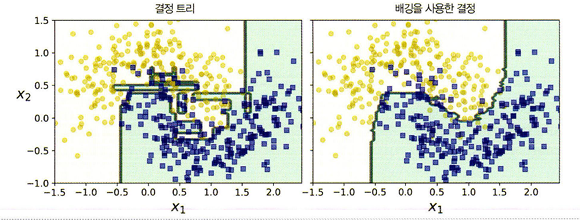

* 앙상블이 트리 하나의 예측보다 일반화가 훨씬 잘됨
* 배깅과 페이스팅 모두 평가해서 더 나은 쪽을 선택하는 것이 좋음

#### 7.2.2 oob 평가
BaggingClassifier는 기본적으로 중복을 허용하여 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링되는데, 선택되지 않은 나머지 37%의 훈련 샘플을 oob(out-of-bag) 샘플이라고 부름 (예측기마다 남겨진 37%는 모두 다름)  
그러므로 oob 샘플을 검증 세트로 사용하여 예측기의 성능을 평가할 수 있음
* oob_score=True로 지정


In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.95

* 테스트 세트에서도 oob 평가 결과와 비슷한 정확도를 얻을 것으로 보임

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

* oob 샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인 가능

In [ ]:
bag_clf.oob_decision_function_

array([[0.21142857, 0.78857143],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.94623656, 0.05376344],
       [0.02222222, 0.97777778],
       [0.97860963, 0.02139037],
       [1.        , 0.        ],
       [0.98324022, 0.01675978],
       [0.58974359, 0.41025641],
       [0.75      , 0.25      ],
       [0.01162791, 0.98837209],
       [0.98809524, 0.01190476],
       [0.02105263, 0.97894737],
       [0.        , 1.        ],
       [0.00628931, 0.99371069],
       [0.98514851, 0.01485149],
       [1.        , 0.        ],
       [0.18539326, 0.81460674],
       [0.96449704, 0.03550296],
       [0.00534759, 0.99465241],
       [0.88944724, 0.11055276],
       [0.13294798, 0.86705202],
       [0.97777778, 0.02222222],
       [0.09782609, 0.90217391],
       [0.21495327, 0.78504673],
       [1.        , 0.        ],
       [0.2967033 , 0.7032967 ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.09895833, 0.90104167],
       [0.

### 7.3 랜덤 배치와 랜덤 서브스페이스
Bagging 분류기는 특성 샘플링도 지원함, max_features, bootstrap_features 두 매개변수로 조절  
랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것  
랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것 (즉 훈련 샘플은 bootstrap=False, max_samples=1.0 / 특성은 True, 1.0 보다 작게)

### 7.4 랜덤 포레스트


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

#### 7.4.1 엑스트라 트리
익스트림 랜덤 트리 앙상블 : 극단적으로 무작위한 트리의 랜덤 포레스트
* ExtraTreesClassifier 사용

#### 7.4.2 특성 중요도
랜덤 포레스트는 특성의 상대적 중요도 측정하기 쉬움
* feature_importances_ 변수

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10077764557710266
sepal width (cm) 0.021871829969703063
petal length (cm) 0.42172174569498727
petal width (cm) 0.455628778758207


### 7.5 부스팅
에이다부스트, 그레이디언트 부스팅

#### 7.5.1 에이다부스트
이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여서 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 되는 방식 (이전 예측기를 보완)

* 첫번째 분류기는 많은 샘플을 잘못 분류, 이 샘플들의 가중치가 높아져 두번째 분류기는 더 정확히 예측
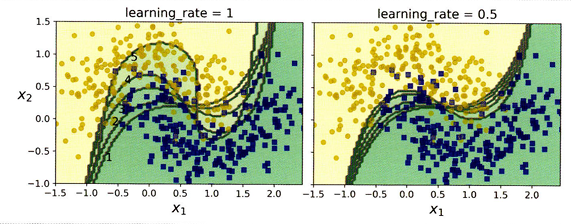

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

#### 7.5.2 그래이디언트 부스팅
이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴
* 그레이디언트 트리 부스팅 또는 그레이디언트 부스티드 회귀 트리

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

* 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됨

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

* 트리가 앙상블에 추가될수록 예측이 점점 좋아지는 것 알 수 있음
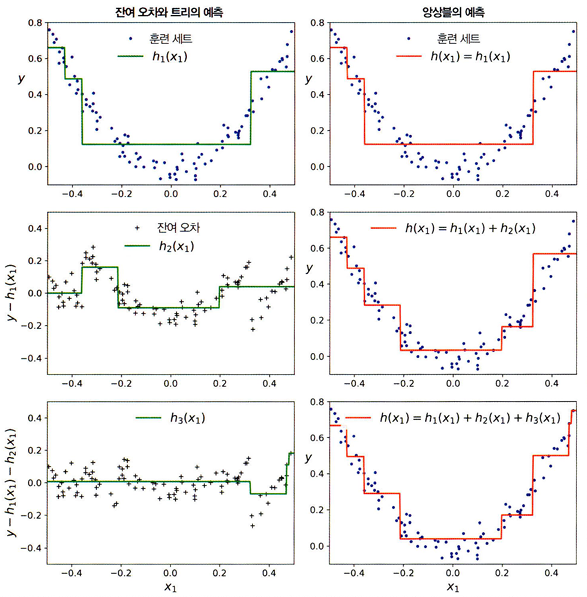

* GBRT 앙상블은 GradientBoostingRegressor 사용

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

* 최적의 트리 수 찾기 간단하게 구현하려면 staged_predict() 사용

In [ ]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=76)

* 또는 warm_start=True로 설정하여 조기 종료 구현 가능

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break   # 조기 종료

* GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수 지원 (확률적 그레이디언트 부스팅)

* XGBoost : 최적화된 그레이디언트 부스팅

In [ ]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [ ]:
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.38189
[1]	validation_0-rmse:0.30074
[2]	validation_0-rmse:0.25006
[3]	validation_0-rmse:0.22548
[4]	validation_0-rmse:0.21560
[5]	validation_0-rmse:0.19308
[6]	validation_0-rmse:0.17478
[7]	validation_0-rmse:0.16186
[8]	validation_0-rmse:0.15238
[9]	validation_0-rmse:0.14411
[10]	validation_0-rmse:0.14297
[11]	validation_0-rmse:0.13745
[12]	validation_0-rmse:0.13534
[13]	validation_0-rmse:0.13483
[14]	validation_0-rmse:0.13455
[15]	validation_0-rmse:0.13478


### 7.6 스태킹
여러 분류기가 각각 다른 값을 예측하고 마지막 예측기(블렌더 또는 메타 학습기)가 이 예측을 입력으로 받아 최종 예측 만듬  
홀드 아웃 세트 사용하여 블렌더 학습시킴
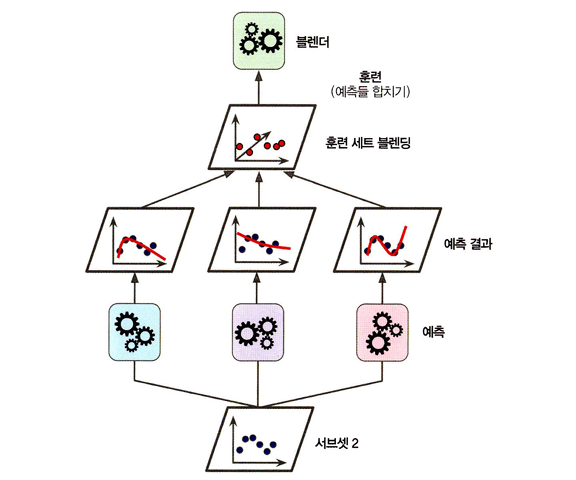
